In [10]:
pip install datashader

  Obtaining dependency information for datashader from https://files.pythonhosted.org/packages/ee/ba/978258937f44bf270de7ed8bd6d4386949cddc7a1660fe1c558cbd3d8809/datashader-0.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for colorcet from https://files.pythonhosted.org/packages/c6/c6/9963d588cc3d75d766c819e0377a168ef83cf3316a92769971527a1ad1de/colorcet-3.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for param from https://files.pythonhosted.org/packages/25/7e/8bc23416cf4cd6ded2eaf78e09f90c97975987f705d23075b4d3bfbc065a/param-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyct from https://files.pythonhosted.org/packages/75/e7/c7c1e9e1b6b23ca1db7af3c6826d57d8da883021f751edcc9c82143b127a/pyct-0.5.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.meta

In [2]:
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.multioutput import RegressorChain
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd
import pickle
import seaborn as sb


## Preamble
Here I model the OASIM data using multi output regression within a frequentist setting. I use Random Forest (RF) models following two approaches. The first is a straight multi-output  RF regressor. The second uses RF wrapped in a regressor chain framework, which is similar to hierarchical modeling in that it expects some relathionships between the target variables (concentrations of phytoplankton types in this case).

In [3]:
# load data
project_path = Path.cwd().parent
data_path = project_path / 'data' 
preprocessed_data_path = data_path / '02_extracted' / 'pcc_sims/subset'
assert preprocessed_data_path.exists()

In [14]:
current_file_path = Path(__file__).resolve()  # Get the absolute path of the scrip

NameError: name '__file__' is not defined

In [4]:
df_phy = pd.read_parquet(
    preprocessed_data_path / 'df_nwa_phyto.pqt'
)
df_rrs = pd.read_parquet(
    preprocessed_data_path / 'df_nwa_rrs.pqt'
)


## EDA


In [5]:
df_phy.head(3).T

,0,1,18
dia,3.078860e-02,1.638420e-02,2.568477e-02
chl,1.793516e-01,1.990273e-01,1.117296e-01
cya,6.528870e-03,7.706301e-03,4.860278e-03
coc,8.983515e-06,4.708744e-06,8.923982e-06
din,9.488947e-21,5.576407e-21,1.796773e-19
pha,1.536091e-33,8.309722e-33,4.965661e-34
tot_cphyl,2.166781e-01,2.231225e-01,1.422836e-01


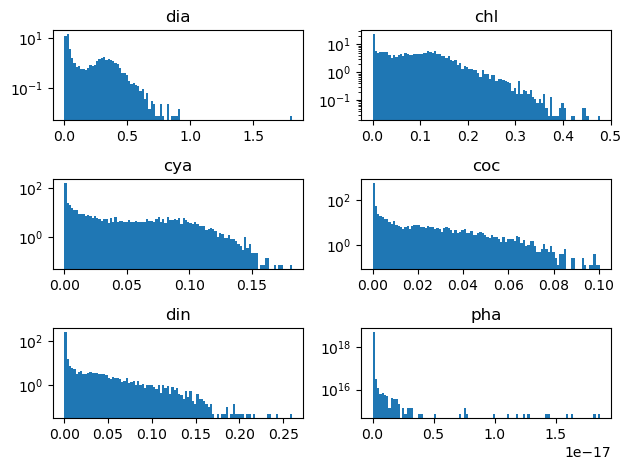

In [9]:
f, axs = pp.subplots(ncols=2, nrows=3)
for col, ax in zip(df_phy.columns, axs.ravel()):
    ax.hist(df_phy.loc[:, col], bins=100, density=True, log=True)
    ax.set_title(col)
f.tight_layout()

In [5]:
# Split data set
rrs_train, rrs_test, phy_train, phy_test = train_test_split(
    df_rrs, df_phy, test_size=0.3, random_state=42, shuffle=True
)

Assessing relationships between target variables

In [20]:
corr.iloc[:-1, :-1]

,dia,chl,cya,coc,din,pha
dia,1.000000,-0.414231,-0.645749,-0.422498,0.714199,0.069704
chl,-0.414231,1.000000,-0.032312,-0.223559,-0.448429,-0.055709
cya,-0.645749,-0.032312,1.000000,0.782774,-0.421821,-0.045474
coc,-0.422498,-0.223559,0.782774,1.000000,-0.264810,-0.016838
din,0.714199,-0.448429,-0.421821,-0.264810,1.000000,0.049805
pha,0.069704,-0.055709,-0.045474,-0.016838,0.049805,1.000000


array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

<Axes: >

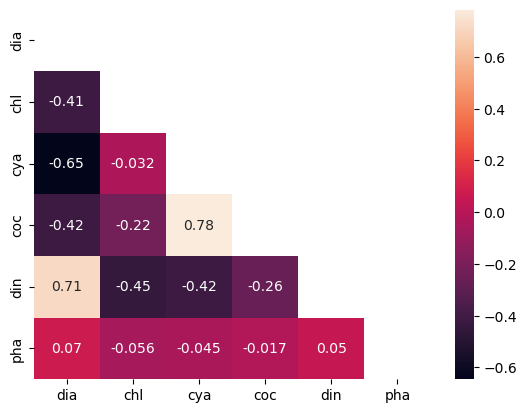

In [31]:
corr = phy_train.corr().iloc[:-1, :-1]
mask = np.triu(np.ones_like(corr, dtype=bool))
f = pp.figure()
ax = f.add_subplot()
sb.heatmap(corr, mask=mask, annot=True, ax=ax)
#ax.set_xticks(ax.get_xticks()[:-1]);
#ax.set_yticks(ax.get_yticks()[:-])

In [62]:
from matplotlib import colormaps
cm = colormaps['bwr']

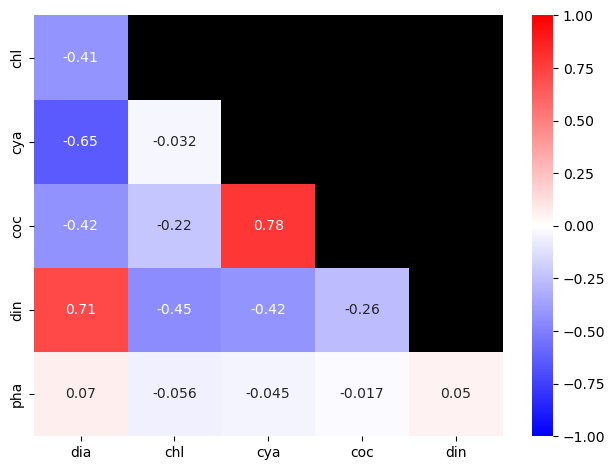

In [63]:

corr = phy_train.corr().iloc[:-1, :-1]
mask = np.triu(np.ones_like(corr, dtype=bool))
f = pp.figure()
ax = f.add_subplot()
sb.heatmap(corr, mask=mask, annot=True, ax=ax, vmin=-1, vmax=1, cmap=cm)
ax.set_xticks(ax.get_xticks()[:-1])
ax.set_yticks(ax.get_yticks()[1:])
x_lim, y_lim = mask.shape
x_lim = (0, x_lim -1)
y_lim = (y_lim, 1)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_facecolor('k')
f.tight_layout()

((0.0, 6.0), (6.0, 0.0))

In [54]:
ax.get_xticks(), ax.get_xticks()[:-1]

(array([0.5, 1.5, 2.5, 3.5, 4.5]), array([0.5, 1.5, 2.5, 3.5]))

In [64]:
rf_base = RandomForestRegressor()


In [65]:
rf_base.fit(rrs_train, phy_train)

RandomForestRegressor()

In [100]:
base_pred = rf_base.predict(rrs_test)
base_pred = pd.DataFrame(base_pred, columns=phy_test.columns)
base_r2 = pd.Series(
    r2_score(phy_test, base_pred, multioutput='raw_values'),
    index=phy_test.columns)
base_mae = pd.Series(
    mean_absolute_error(
        phy_test, base_pred, multioutput='raw_values'),
        index=phy_test.columns)
base_mdae = pd.Series(
    median_absolute_error(
    phy_test, base_pred, multioutput='raw_values'),
    index=phy_test.columns)
base_scores = pd.concat((base_r2, base_mae, base_mdae), axis=1)
base_scores.columns = ['R2', 'MAE', 'MedAE']

In [72]:
base_scores

,R2,MAE,MedAE
dia,0.894178,2.758810e-02,9.837954e-03
chl,0.686059,2.731229e-02,1.701194e-02
cya,0.972837,3.809434e-03,2.309182e-03
coc,0.717242,4.896998e-03,1.009150e-03
din,0.658760,9.280123e-03,6.662621e-04
pha,-0.007104,8.207213e-20,5.502242e-21
tot_cphyl,0.947727,1.553038e-02,1.006482e-02


In [74]:
rf_chain = RegressorChain(RandomForestRegressor())

In [75]:
rf_chain.fit(rrs_train, phy_train)

RegressorChain(base_estimator=RandomForestRegressor())

In [98]:
chain_pred = rf_base.predict(rrs_test)
chain_pred = pd.DataFrame(chain_pred, columns=phy_test.columns)
chain_r2 = pd.Series(
    r2_score(phy_test, chain_pred, multioutput='raw_values'),
    index=phy_test.columns)
chain_mae = pd.Series(
    mean_absolute_error(
        phy_test, chain_pred, multioutput='raw_values'),
        index=phy_test.columns)
chain_mdae = pd.Series(
    median_absolute_error(
    phy_test, chain_pred, multioutput='raw_values'),
    index=phy_test.columns)
chain_scores = pd.concat((chain_r2, chain_mae, chain_mdae), axis=1)
chain_scores.columns = ['R2', 'MAE', 'MedAE']

In [77]:
chain_scores

,R2,MAE,MedAE
dia,0.894178,2.758810e-02,9.837954e-03
chl,0.686059,2.731229e-02,1.701194e-02
cya,0.972837,3.809434e-03,2.309182e-03
coc,0.717242,4.896998e-03,1.009150e-03
din,0.658760,9.280123e-03,6.662621e-04
pha,-0.007104,8.207213e-20,5.502242e-21
tot_cphyl,0.947727,1.553038e-02,1.006482e-02


### Output Ranges

In [ ]:
def output_range(y_true):
    output_min = y_true.min()
    output_max = y_true.max()
    output_range = output_max - output_min
    print(f"Output Range for {col}: {output_range}")

In [101]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

class PerformanceAnalyzer:
    def __init__(self, y_true:pd.DataFrame, y_pred:pd.DataFrame):
        self.y_true = y_true
        self.y_pred = y_pred
        self.phyto = y_true.columns.tolist()

    def calculate_output_ranges(self):
        """Calculates the output range for each column in a DataFrame.

        Args:
            df (pd.DataFrame): Data containing the target outputs.

        Prints:
            Output Range for each column.
        """
        self.ranges = pd.Series(index=self.y_true.columns)
        for col in self.phyto:
            output_min = self.y_true[col].min()
            output_max = self.y_true[col].max()
            output_range = output_max - output_min
            self.ranges[col] = output_range
            print(f"Output Range for {col}: {output_range}")

    def plot_error_distributions(self):
        """Plots error distributions for each output.

        Args:
            y_true (pd.DataFrame): True outputs.
            y_pred (pd.DataFrame): Predicted outputs.

        """
        
        for col in self.phyto:
            errors = self.y_pred[col] - self.y_true[col]
            pp.figure(figsize=(8, 6))
            pp.hist(errors)
            pp.xlabel("Prediction Error")
            pp.ylabel("Frequency")
            pp.title(f"Distribution of Errors for {col}")
            pp.show()

    def plot_predictions_vs_true(y_true, y_pred):
        """Plots scatter plots of predictions vs. true values for each output.

        Args:
            y_true (pd.DataFrame): True outputs.
            y_pred (pd.DataFrame): Predicted outputs.
        """    
        for col in y_true.columns:
            pp.figure(figsize=(8, 6))
            pp.scatter(y_true[col], y_pred[col])
            pp.xlabel("True Values")
            pp.ylabel("Predicted Values")
            pp.title(f"Predictions vs. True Values for {col}")
            pp.show()

    def calculate_relative_errors(self):
        """Calculates relative percentage errors for each output.

        Args:
            y_true (pd.DataFrame): True outputs.
            y_pred (pd.DataFrame): Predicted outputs.
        """   
        for col in self.phyto:
            errors = self.y_pred[col] - self.y_true[col]
            output_range = self.y_true[col].max() - self.y_true[col].min()
            percentage_errors = (np.abs(errors) / output_range) * 100
            average_percentage_error = percentage_errors.mean()
            print(f"Average Percentage Error for {col}: {average_percentage_error}")

    def plot_residuals(self):
        """Plots residuals vs. predicted values for each output.

        Args:
            y_true (pd.DataFrame): True outputs.
            y_pred (pd.DataFrame): Predicted outputs.
        """   
        for col in self.phyto:
            errors = self.y_pred[col] - self.y_true[col]
            pp.figure(figsize=(8, 6))
            pp.scatter(self.y_pred[col], errors)
            pp.xlabel("Predicted Values")
            pp.ylabel("Residuals")
            pp.title(f"Residuals vs. Predicted Values for {col}")
            pp.show()


In [102]:
pa = PerformanceAnalyzer(y_true=phy_test, y_pred=base_pred)

ValueError: x and y must be the same size

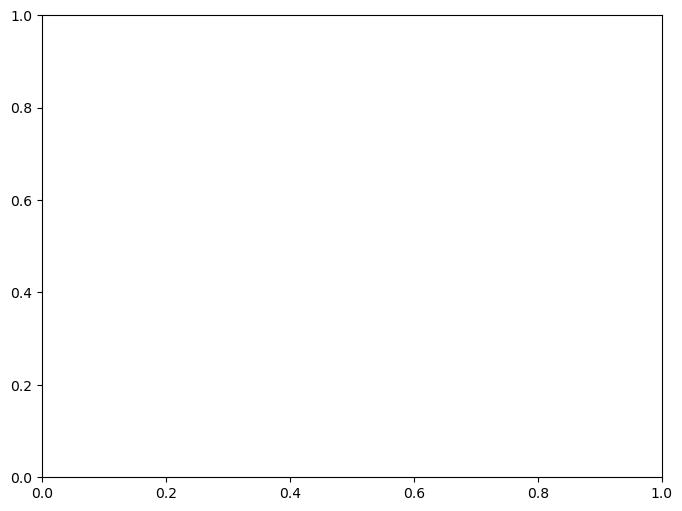

In [103]:
pa.plot_residuals()

In [92]:
base_pred

'dia'

In [107]:
base_pred.head()

,dia,chl,cya,coc,din,pha,tot_cphyl
0,0.295140,0.042277,0.001045,0.000103,0.035002,4.788571e-21,0.373566
1,0.306885,0.014895,0.000339,0.000083,0.023571,3.121076e-21,0.345772
2,0.311159,0.050762,0.000942,0.000262,0.024122,1.336794e-20,0.387247
3,0.025262,0.121243,0.026628,0.000893,0.000074,6.901277e-28,0.174100
4,0.146017,0.180623,0.008192,0.000642,0.005917,2.108619e-22,0.341390


In [108]:
phy_test.head()

,dia,chl,cya,coc,din,pha,tot_cphyl
5685,0.326241,0.000177,3.569409e-07,0.000039,5.887150e-02,7.817683e-25,0.385329
10594,0.324202,0.013483,4.534488e-05,0.000077,8.127738e-03,4.790527e-30,0.345935
8754,0.183752,0.184096,3.096622e-03,0.000061,6.806232e-04,2.220111e-33,0.371687
883,0.026725,0.116046,3.097511e-02,0.000107,2.168457e-10,9.231461e-33,0.173853
7998,0.031228,0.264804,1.199352e-02,0.000086,1.923006e-09,4.331806e-33,0.308112


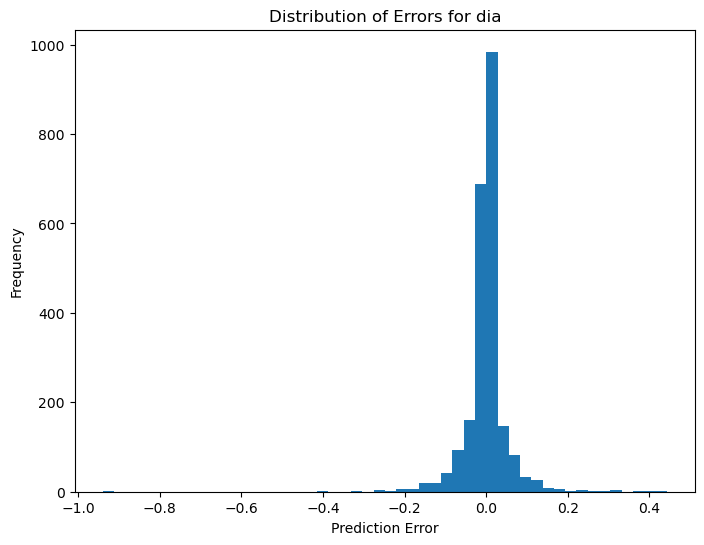

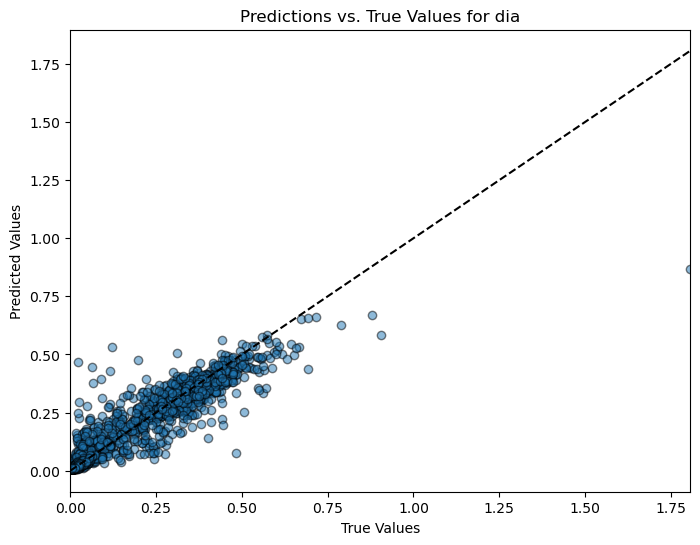

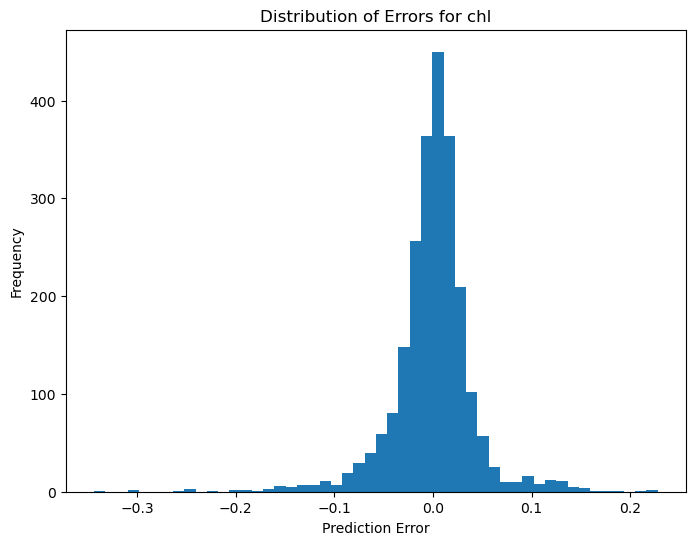

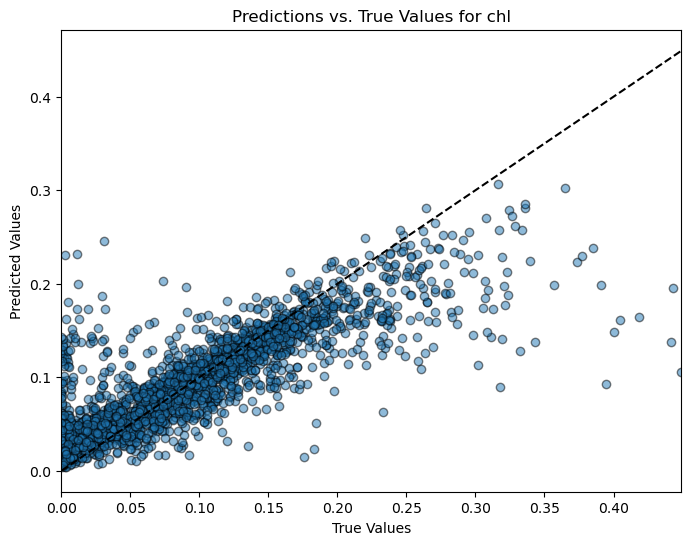

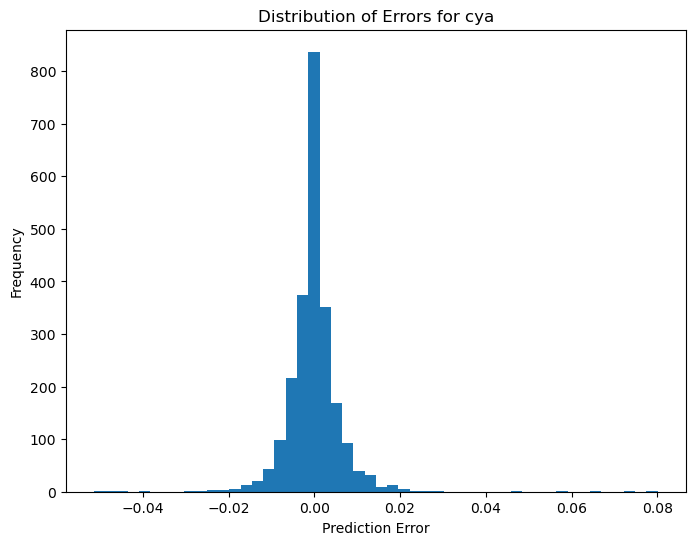

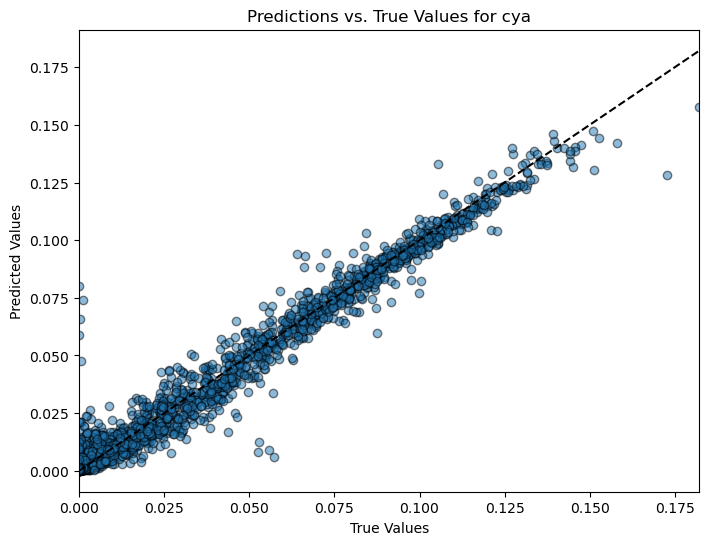

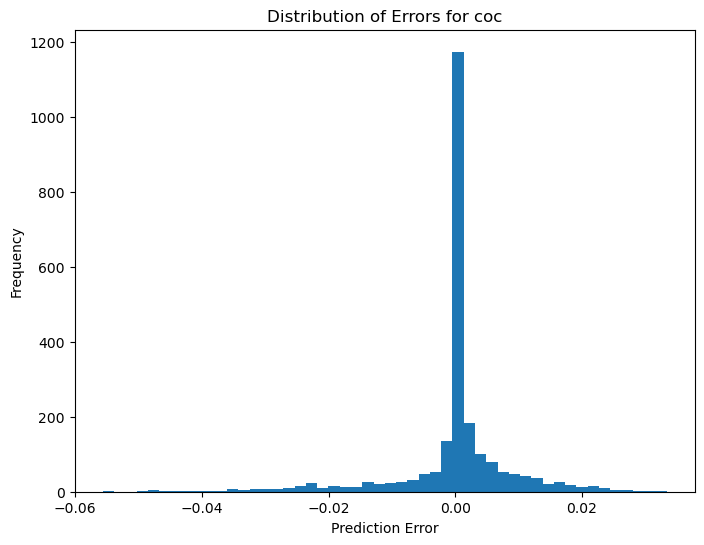

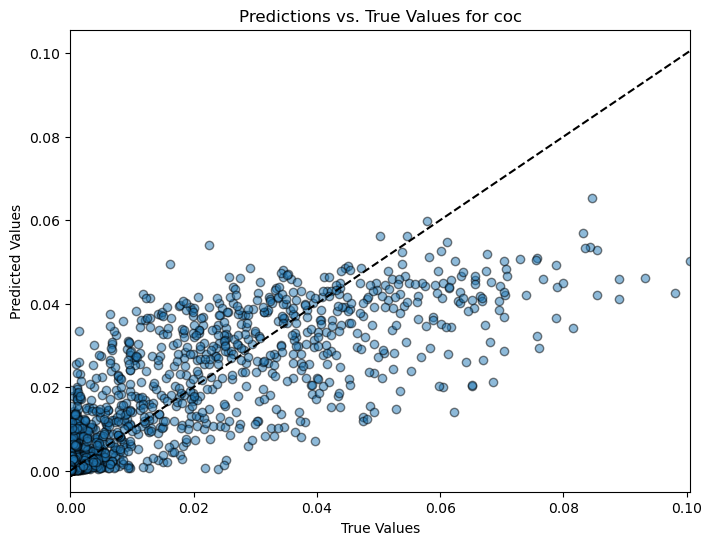

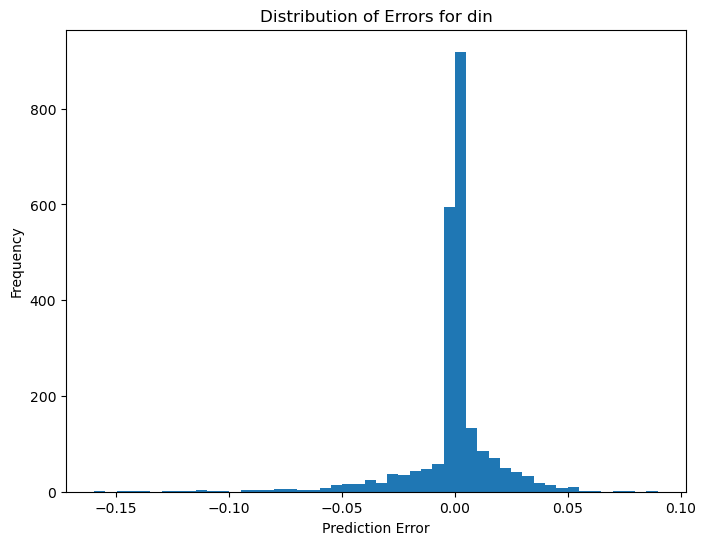

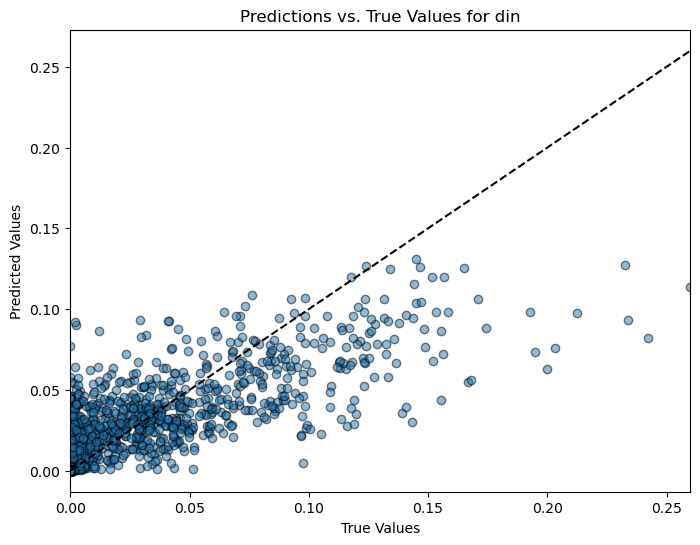

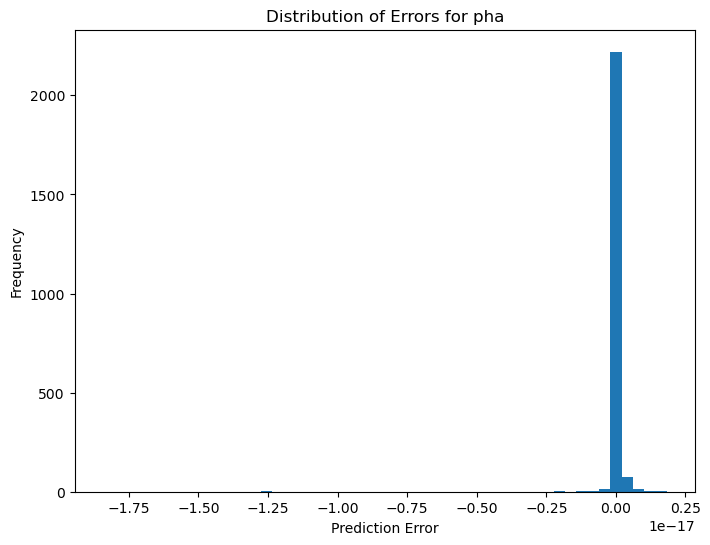

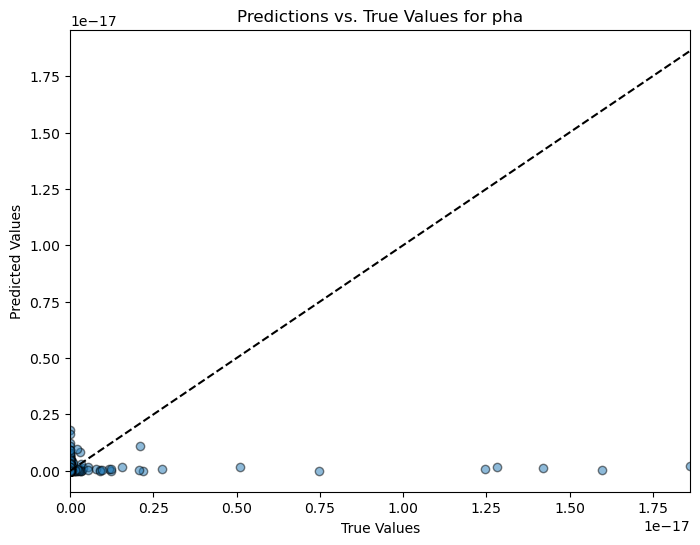

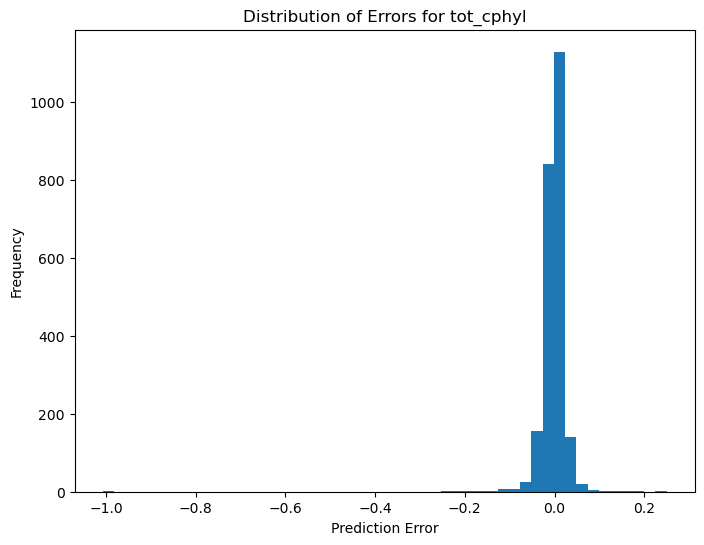

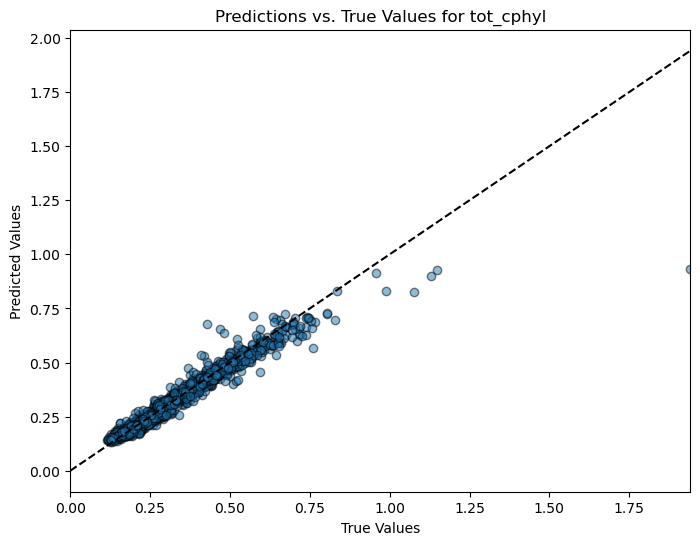

In [142]:
for col in phy_test.columns:
    errors = base_pred[col].values - phy_test[col].values

    # Histograms of errors (consider subplots for multiple outputs)
    pp.figure(figsize=(8, 6)) # Adjust figure size if needed
    pp.hist(errors, bins=50)
    pp.xlabel("Prediction Error")
    pp.ylabel("Frequency")
    pp.title(f"Distribution of Errors for {col}")
    pp.show()

    # Scatter plots 
    pp.figure(figsize=(8, 6))
    pp.scatter(phy_test[col], base_pred[col], alpha=0.5, edgecolor='k')
    pp.xlabel("True Values")
    pp.ylabel("Predicted Values")
    pp.title(f"Predictions vs. True Values for {col}")
    max_all = max(phy_test.loc[:, col].max(), base_pred.loc[:, col].max())
    pp.xlim(0, max_all)
    pp.plot((0, max_all), (0, max_all), 'k--')
    pp.show()


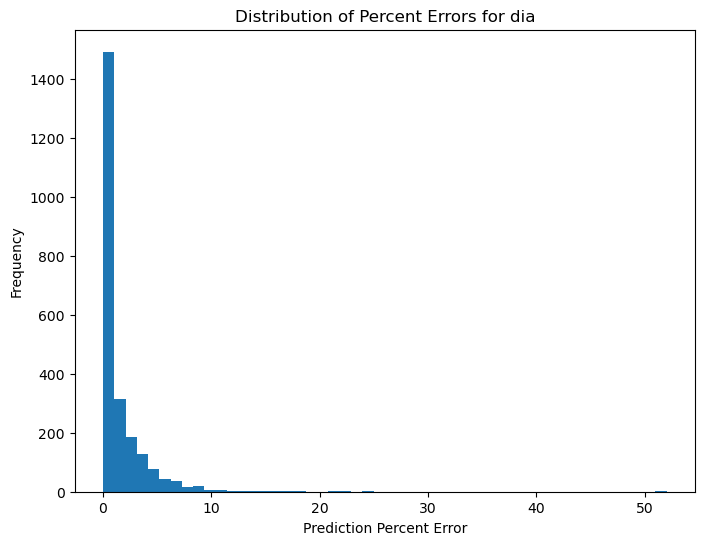

Median Percentage Error for dia: 0.54%
Average Percentage Error for dia: 1.53%
Percentage Error STD for dia: 2.57%


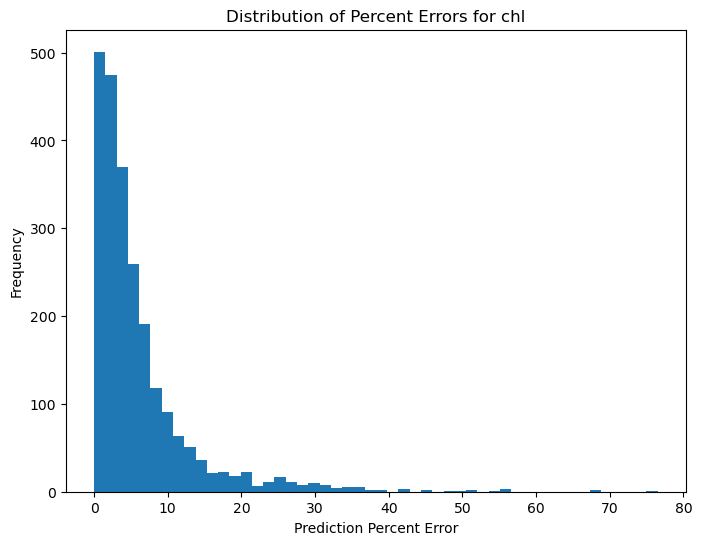

Median Percentage Error for chl: 3.79%
Average Percentage Error for chl: 6.08%
Percentage Error STD for chl: 7.41%


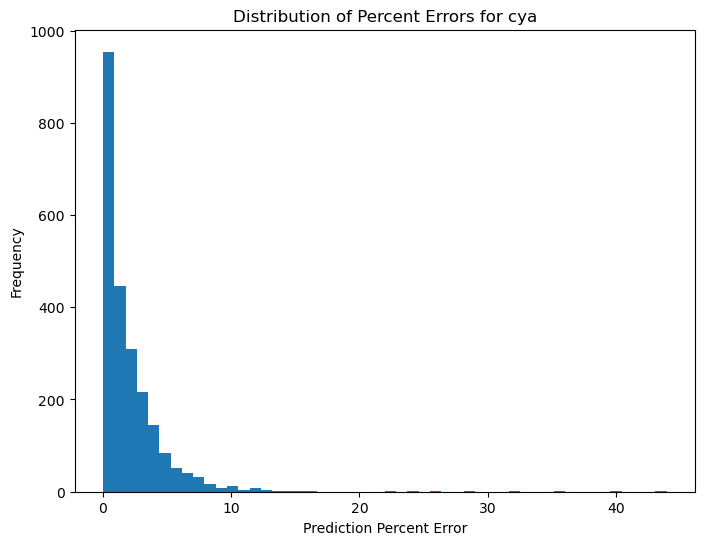

Median Percentage Error for cya: 1.27%
Average Percentage Error for cya: 2.09%
Percentage Error STD for cya: 2.90%


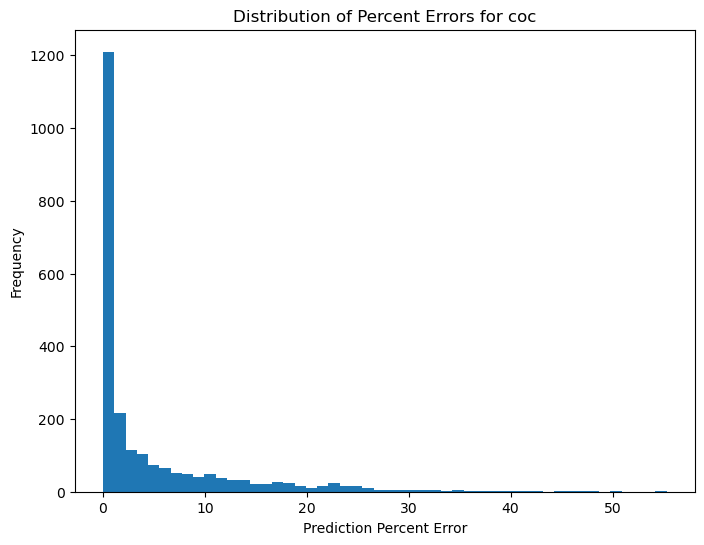

Median Percentage Error for coc: 1.00%
Average Percentage Error for coc: 4.87%
Percentage Error STD for coc: 7.88%


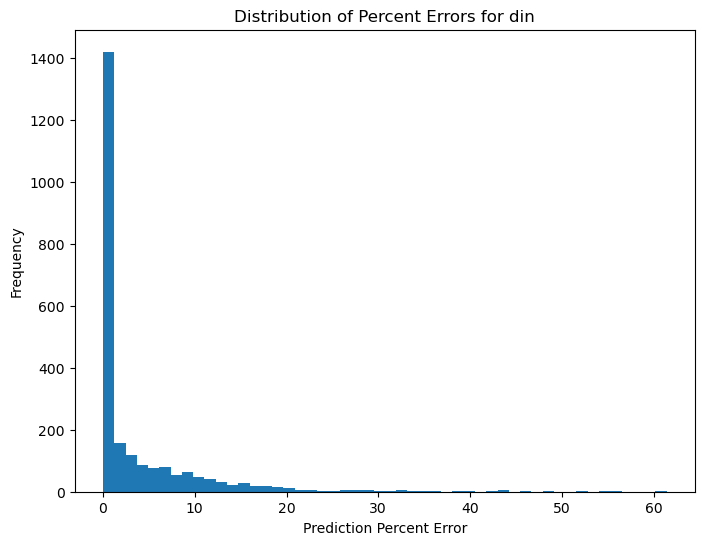

Median Percentage Error for din: 0.26%
Average Percentage Error for din: 3.57%
Percentage Error STD for din: 6.63%


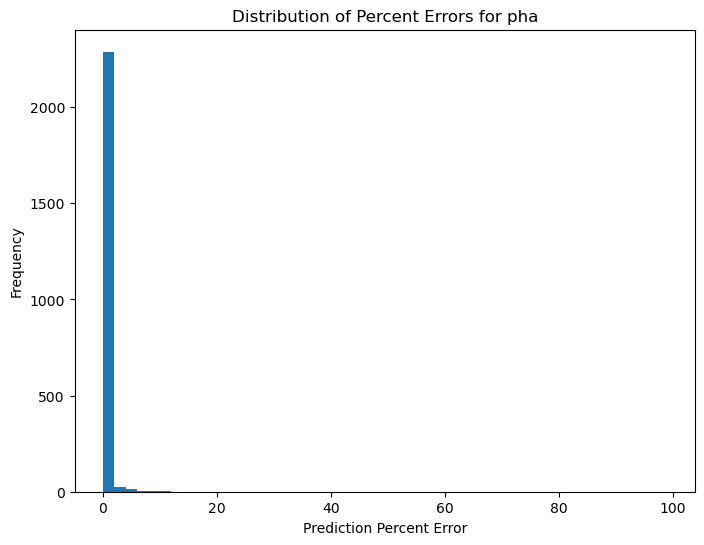

Median Percentage Error for pha: 0.03%
Average Percentage Error for pha: 0.44%
Percentage Error STD for pha: 3.88%


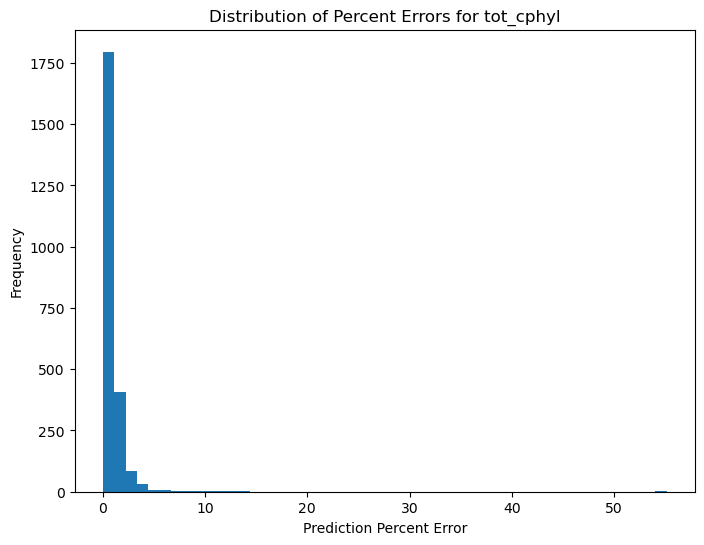

Median Percentage Error for tot_cphyl: 0.55%
Average Percentage Error for tot_cphyl: 0.85%
Percentage Error STD for tot_cphyl: 1.54%


In [140]:
for col in phy_test.columns:
    errors = base_pred[col].values - phy_test[col].values
    output_range = phy_test[col].max() - phy_test[col].min()
    percentage_errors = (np.abs(errors) / output_range) * 100
    pp.figure(figsize=(8, 6)) # Adjust figure size if needed
    pp.hist(percentage_errors, bins=50)
    pp.xlabel("Prediction Percent Error")
    pp.ylabel("Frequency")
    pp.title(f"Distribution of Percent Errors for {col}")
    pp.show()
    average_percentage_error = percentage_errors.mean()
    percentage_error_stdev = percentage_errors.std()
    median_percentage_error = np.nanmedian(percentage_errors)
    print(f"Median Percentage Error for {col}: {median_percentage_error/100:.2%}")
    print(f"Average Percentage Error for {col}: {average_percentage_error/100:.2%}")
    print(f'Percentage Error STD for {col}: {percentage_error_stdev/100:.2%}')

In [ ]:
base_pred

In [127]:
base_pred[col].shape, errors.shape, phy_test.loc[:, col].shape

((2344,), (4168,), (2344,))

In [137]:
base_pred[col].values.shape, phy_test[col].values.shape

((2344,), (2344,))

In [138]:
(base_pred[col].values - phy_test[col].values).shape

(2344,)

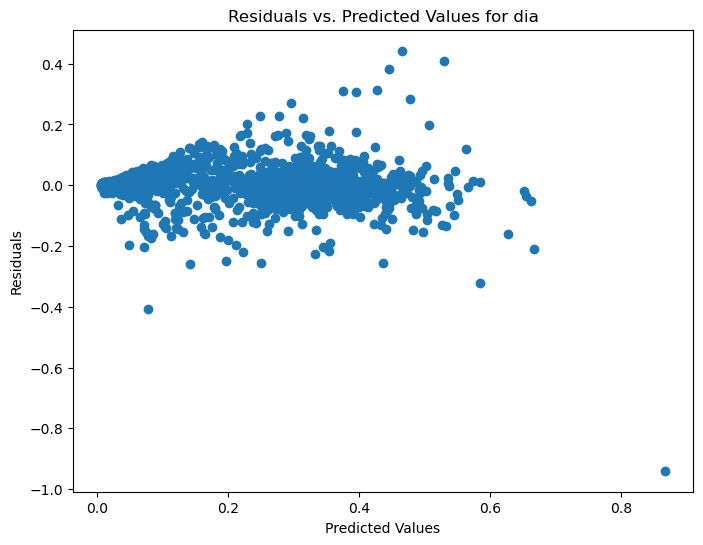

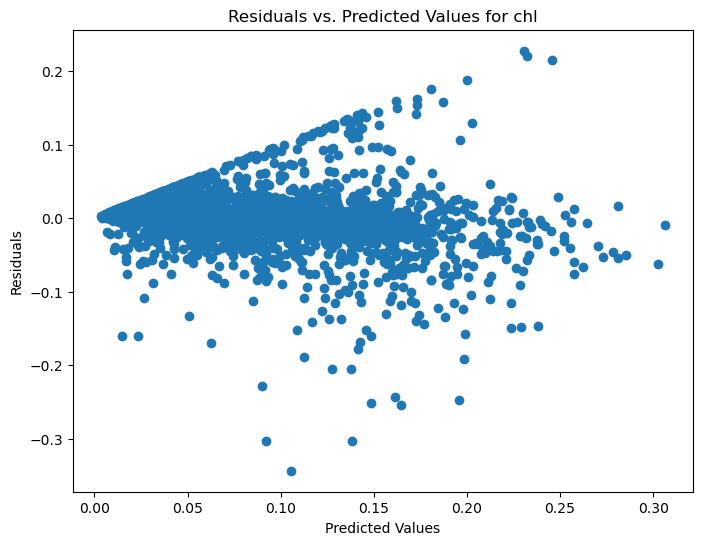

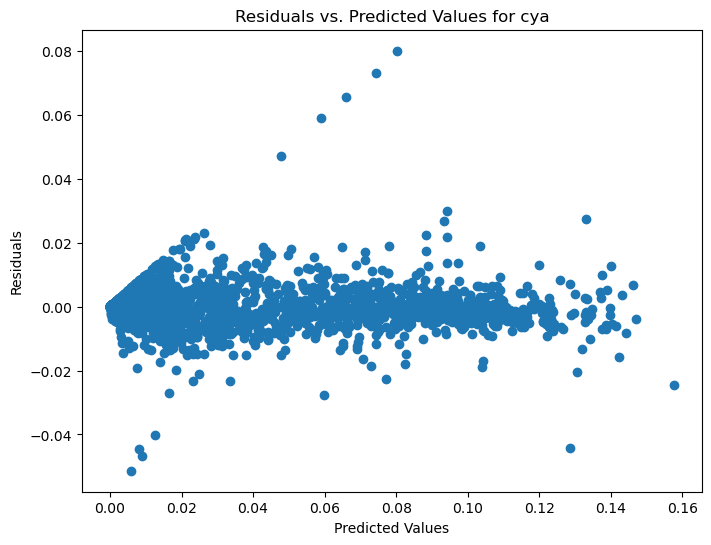

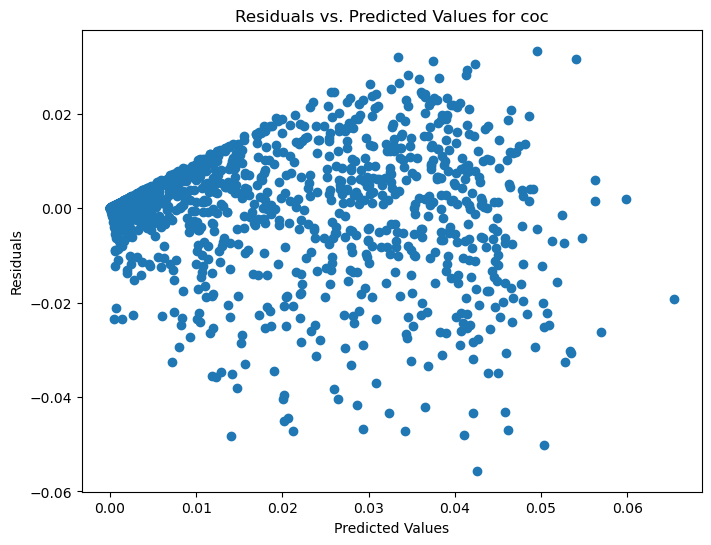

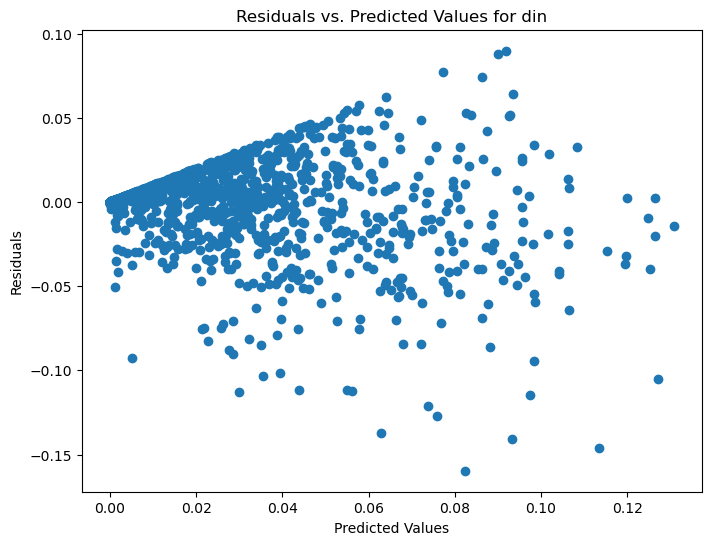

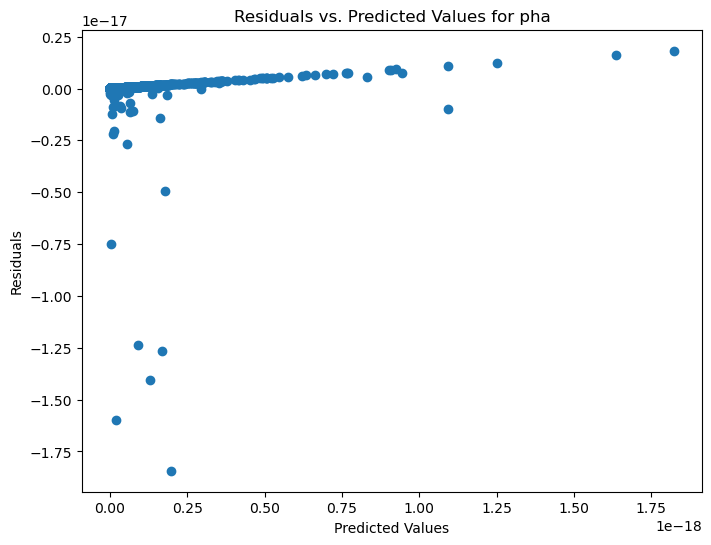

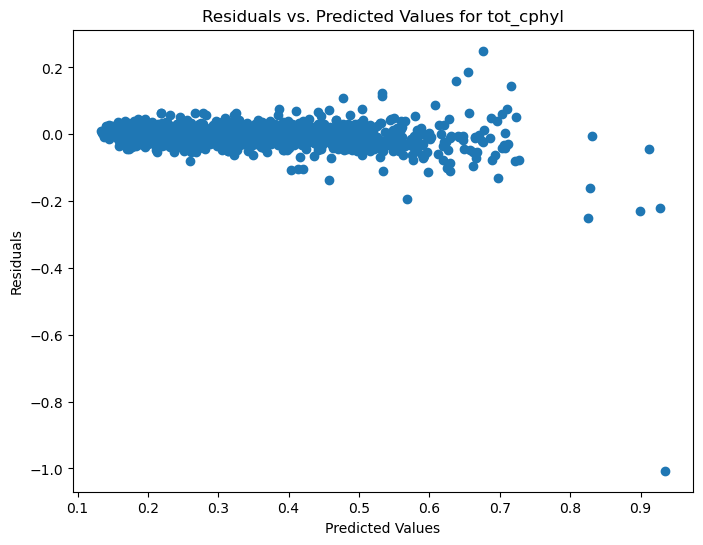

In [139]:
for col in phy_test.columns:
    errors = base_pred[col].values - phy_test[col].values
    plt.figure(figsize=(8, 6))
    plt.scatter(base_pred.loc[:, col], errors)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. Predicted Values for {col}")
    plt.show()